In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0,1
import os, sys
import time
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import lib
import torch, torch.nn as nn
import torch.nn.functional as F
from qhoptim.pyt import QHAdam

# read the data
data = lib.Dataset("EPSILON", random_state=1337, quantile_transform=True, quantile_noise=1e-3)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

experiment_name = 'epsilon_node_2layers'
experiment_name = '{}_{}.{:0>2d}.{:0>2d}_{:0>2d}:{:0>2d}'.format(experiment_name, *time.gmtime()[:5])
print("experiment:", experiment_name)

env: CUDA_VISIBLE_DEVICES=0,1
reading dataset (it may take a long time)
experiment: epsilon_node_2layers_2019.08.28_13:04


__Note:__ make sure you're using torch version `>= 1.1.0`, the code will silently fail even on 1.0.1.

In [2]:
num_features = data.X_train.shape[1]
num_classes = len(set(data.y_train))

model = nn.Sequential(
    lib.DenseBlock(num_features, layer_dim=1024, num_layers=2, tree_dim=num_classes + 1, flatten_output=False,
                   depth=6, choice_function=lib.entmax15, bin_function=lib.entmoid15),
    lib.Lambda(lambda x: x[..., :num_classes].mean(dim=-2)),
).to(device)

with torch.no_grad():
    res = model(torch.as_tensor(data.X_train[:2000], device=device))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)


trainer = lib.Trainer(
    model=model, loss_function=F.cross_entropy,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=dict(nus=(0.7, 1.0), betas=(0.95, 0.998)),
    verbose=True,
    n_last_checkpoints=5
)

In [3]:
from tqdm import tqdm
from IPython.display import clear_output
loss_history, err_history = [], []
best_val_err = 1.0
best_step = 0
early_stopping_rounds = 10_000
report_frequency = 100

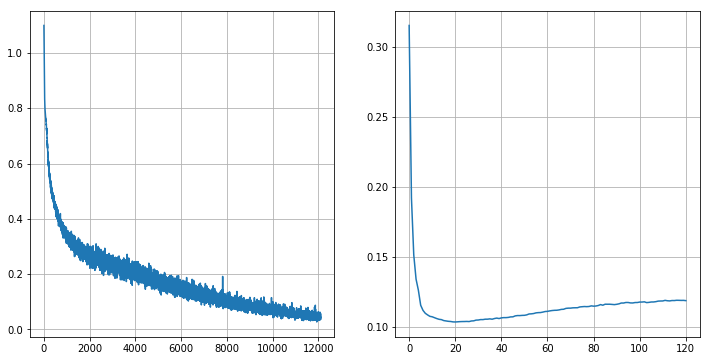

Loss 0.04272
Val Error Rate: 0.11866
BREAK. There is no improvment for 10000 steps
Best step:  2100
Best Val Error Rate: 0.10340


In [4]:
for batch in lib.iterate_minibatches(data.X_train, data.y_train, batch_size=1024, 
                                                shuffle=True, epochs=float('inf')):
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        err = trainer.evaluate_classification_error(
            data.X_valid, data.y_valid, device=device, batch_size=1024)
        
        if err < best_val_err:
            best_val_err = err
            best_step = trainer.step
            trainer.save_checkpoint(tag='best')
        
        err_history.append(err)
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()
            
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(1,2,2)
        plt.plot(err_history)
        plt.grid()
        plt.show()
        print("Loss %.5f" % (metrics['loss']))
        print("Val Error Rate: %0.5f" % (err))
        
    if trainer.step > best_step + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step)
        print("Best Val Error Rate: %0.5f" % (best_val_err))
        break

In [6]:
trainer.load_checkpoint(tag='best')
error_rate = trainer.evaluate_classification_error(data.X_test, data.y_test, device=device, batch_size=1024)
print('Best step: ', trainer.step)
print("Test Error rate: %0.5f" % (error_rate))
trainer.load_checkpoint()

Loaded logs/epsilon_node_2layers_2019.08.28_13:04/checkpoint_best.pth
Best step:  2100
Test Error rate: 0.10372
Loaded logs/epsilon_node_2layers_2019.08.28_13:04/checkpoint_temp_12100.pth


Trainer(
  (model): DataParallel(
    (module): Sequential(
      (0): DenseBlock(
        (0): ODST(in_features=2000, num_trees=1024, depth=6, tree_dim=3, flatten_output=True)
        (1): ODST(in_features=5072, num_trees=1024, depth=6, tree_dim=3, flatten_output=True)
      )
      (1): Lambda()
    )
  )
)